In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 
import graphviz

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12

In [25]:
train = pd.read_csv('./dataset/Loan information.csv')
target = 'Disbursed'
IDcol = 'ID'

## python api探究

## 1.主要数据结构：
### xgboost.DMatrix(data, label=None, missing=None, weight=None, silent=False, feature_names=None, feature_types=None, nthread=None)    （内部使用的数据结构）
### xgboost.Booster(params=None, cache=(), model_file=None) （基本学习器）

## 2.学习API   (注意：参数定了也就相当于模型定了)
### 用给定的参数训练模型
### xgboost.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)     

### 用给定的参数进行交叉验证 
### xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)  
early_stopping_rounds=N （在训练的过程中，记录最佳的validation accuracy，当连续N次epoch（或者更多次）没达到最佳accuracy时，可以认为“不再提高”，此时使用early stopping。）

# 3.绘图API
### xgboost.plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, **kwargs)¶
### xgboost.plot_tree(booster, fmap='', num_trees=0, rankdir='UT', ax=None, **kwargs)

## 4.Scikit-Learn API
### xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
### xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
#### evals_result() 返回评估结果
#### fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True)  相当于train

In [26]:
predictors = [x for x in train.columns if x not in [target,IDcol]]
dtrain = xgb.DMatrix(train[predictors].values, label=train[target].values,feature_names=predictors)#构造

In [27]:
param={'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}
booster=xgb.train(param,dtrain)

In [7]:
type(booster)

xgboost.core.Booster

In [28]:
dtest = xgb.DMatrix(train[predictors].values,feature_names=predictors)
predictions=booster.predict(dtest)#注意xgb接收的数据结构是DMatrix

In [29]:
cv_result=xgb.cv(param,dtrain,num_boost_round=100,nfold=5,metrics='auc',early_stopping_rounds=50)
cv_result

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.765980,0.013074,0.770105,0.012648
1,0.791815,0.019805,0.797879,0.006949
2,0.803918,0.019349,0.809595,0.004482
3,0.802861,0.021466,0.811680,0.005589
4,0.808680,0.017278,0.818140,0.007905
5,0.811605,0.016981,0.820571,0.008872
6,0.815010,0.016898,0.826477,0.005617
7,0.818460,0.017575,0.829731,0.004986
8,0.819429,0.017417,0.832536,0.004061
9,0.821038,0.018386,0.835061,0.004060


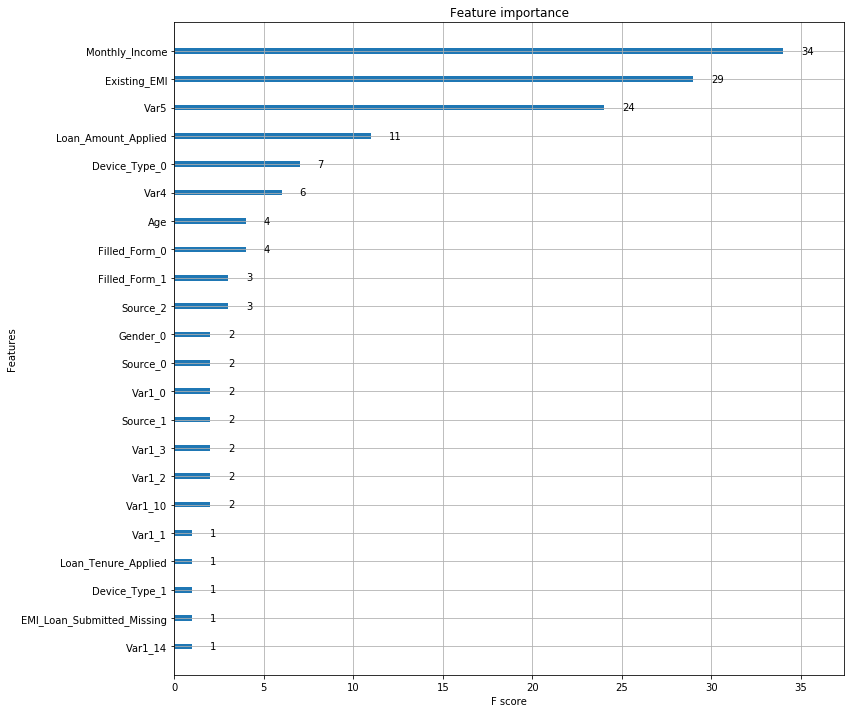

In [15]:
xgb.plot_importance(booster)

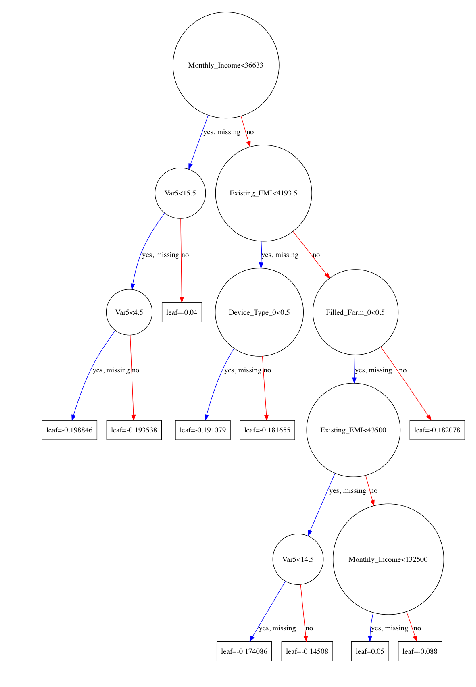

In [7]:
xgb.plot_tree(booster)

In [14]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=27)
type(xgb1)

xgboost.sklearn.XGBClassifier

In [15]:
xgb1.fit(train[predictors],train['Disbursed'],eval_metric='auc')#训练模型,注意数据结构不是DMatrix了

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [18]:
xgb1.evals_result()#  ??

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [20]:
dtrain_predictions = xgb1.predict(train[predictors])
dtrain_predictions

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [22]:
dtrain_predprob = xgb1.predict_proba(train[predictors])[:,1]
dtrain_predprob

array([ 0.00626409,  0.02639912,  0.00792859, ...,  0.04323023,
        0.05599913,  0.02282634], dtype=float32)

In [38]:
type(cv_result.iloc[1,1])

numpy.float64